Problem Statement:

Commodity prices, such as gold, oil, and agricultural products, exhibit trends and seasonal fluctuations influenced by global and local economic factors. Predicting these prices is crucial for traders, policymakers, and businesses to make informed decisions. This project focuses on developing a forecasting model that predicts future commodity prices based on historical data using ARIMA/SARIMA. The goal is to capture underlying trends and seasonal patterns, providing stakeholders with reliable predictions for planning and investment.

Objectives

Forecast Future Prices: Develop a robust ARIMA/SARIMA-based model to predict future prices of commodities such as gold, oil, and agricultural products.

Capture Trends and Seasonality: Identify underlying patterns, trends, and seasonal fluctuations in historical commodity price data.

Enable Data-Driven Decisions: Provide actionable insights for traders, investors, and policymakers to make informed decisions.

Interactive User Input: Allow users to select a commodity and obtain dynamic forecasts along with visualizations.

Evaluate Forecast Accuracy: Measure model performance using metrics such as RMSE, MAPE, and confidence intervals to ensure reliability.

Scope

Applicable Commodities: The system will cover a range of commodities, including precious metals (gold, silver), crude oil, and selected agricultural products (wheat, rice, etc.).

Forecast Horizon: Short-term (daily/weekly) and medium-term (monthly) forecasts based on historical data.

Data Sources: Reliable public datasets from sources like yfinance, Quandl, and Kaggle.

Visualization: Graphical representation of historical trends, seasonal decomposition, and predicted values to enhance interpretability.

Stakeholders: Traders, investors, commodity analysts, policymakers, and businesses involved in commodity trading and planning.

Limitations: Forecast accuracy depends on historical patterns and external factors like global crises, market shocks, or government policies that may not be captured in the model.

In [8]:
import yfinance as yf

# User input
commodity = input("Enter commodity ticker : GC for Gold, CL for CrudeOil, PL for Platinum etc ")

# Fetch historical data
data = yf.download(commodity, start="2015-01-01", end="2025-06-01")
data = data[['Close']]  # Only close price
data.rename(columns={'Close': 'Price'}, inplace=True)
data.to_csv(f"{commodity}_data.csv")
print("Data downloaded successfully!")


C:\Users\shreyas\AppData\Local\Temp\ipykernel_7244\344980089.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(commodity, start="2015-01-01", end="2025-06-01")
[*********************100%***********************]  1 of 1 completed

Data downloaded successfully!


Some Commodities might show error as they might have too many missing/constant values or the data is to short.


In [9]:
print(data.index)
print(type(data.index))
import pandas as pd

# Ensure index is datetime
data.index = pd.to_datetime(data.index)

# Set frequency: 'D' for daily, 'M' for monthly
data = data.asfreq('D')  # or 'M' for monthly data

# Forward fill any missing values created by asfreq
data['Price'] = data['Price'].ffill()
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data['Price'],
                order=(1,1,1),
                seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)
forecast = model_fit.get_forecast(steps=30)
forecast_df = forecast.summary_frame()

# Create datetime index starting after last historical date
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_df.index = forecast_index


DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2025-05-16', '2025-05-19', '2025-05-20', '2025-05-21',
               '2025-05-22', '2025-05-23', '2025-05-27', '2025-05-28',
               '2025-05-29', '2025-05-30'],
              dtype='datetime64[ns]', name='Date', length=2618, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


c:\Users\shreyas\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


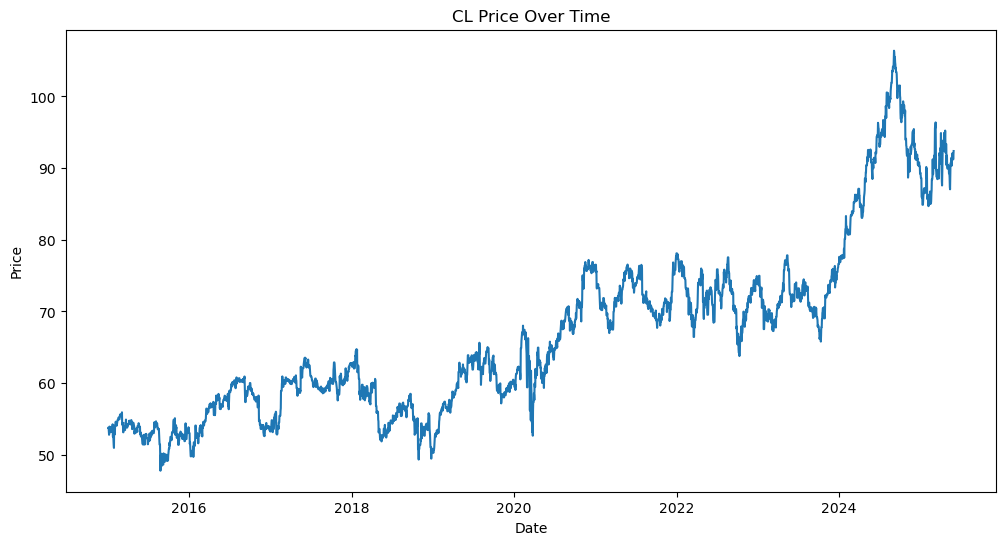

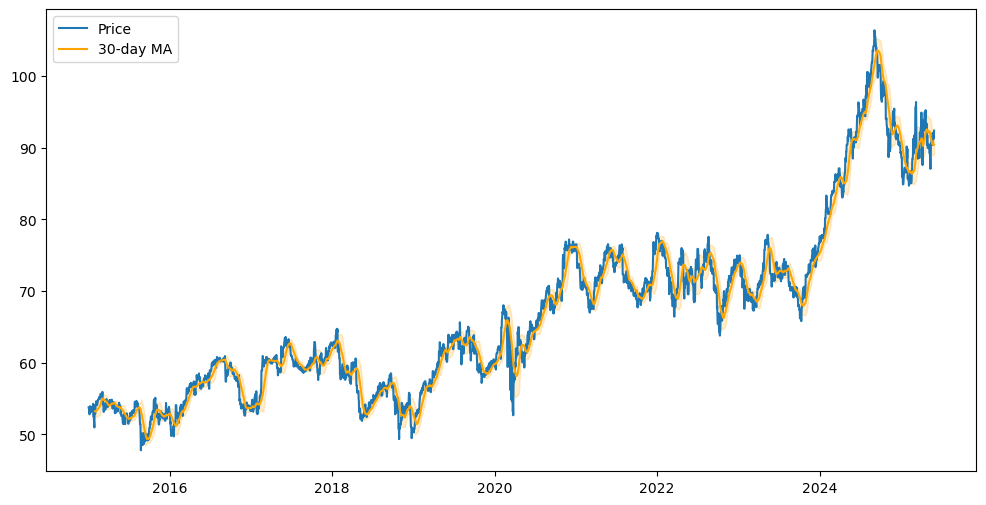

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Line plot of price
plt.figure(figsize=(12,6))
plt.plot(data['Price'])
plt.title(f'{commodity} Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Optional: plot rolling mean & standard deviation
data['MA_30'] = data['Price'].rolling(30).mean()
data['STD_30'] = data['Price'].rolling(30).std()
plt.figure(figsize=(12,6))
plt.plot(data['Price'], label='Price')
plt.plot(data['MA_30'], label='30-day MA', color='orange')
plt.fill_between(data.index, data['MA_30']-data['STD_30'], data['MA_30']+data['STD_30'], color='orange', alpha=0.2)
plt.legend()
plt.show()


In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Price'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If p-value > 0.05 → series is non-stationary, apply differencing
data['Price_diff'] = data['Price'].diff().dropna()


ADF Statistic: -0.7894587914586042
p-value: 0.8221988744212332


In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data['Price'],
                order=(1,1,1),
                seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)
print(model_fit.summary())


c:\Users\shreyas\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                 CL   No. Observations:                 3802
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3881.362
Date:                            Mon, 08 Sep 2025   AIC                           7772.723
Time:                                    17:18:23   BIC                           7803.922
Sample:                                01-02-2015   HQIC                          7783.813
                                     - 05-30-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0770      0.149      0.515      0.606      -0.216       0.370
ma.L1         -0.1642      0.150   

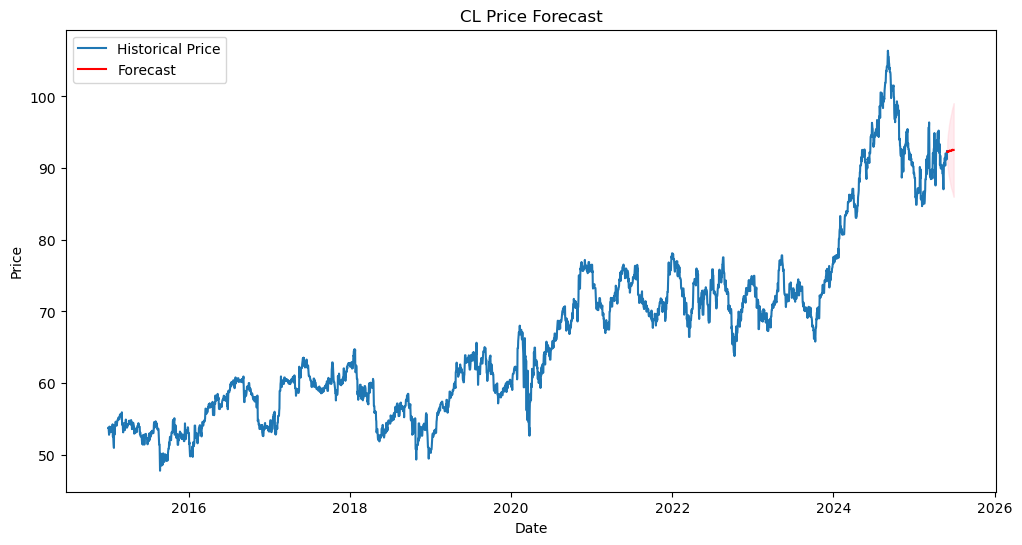

In [13]:
# Forecast next 30 days
forecast = model_fit.get_forecast(steps=30)
forecast_df = forecast.summary_frame()

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(data['Price'], label='Historical Price')
plt.plot(forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='pink', alpha=0.3)
plt.title(f'{commodity} Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data into train/test
train = data['Price'][:-30]
test = data['Price'][-30:]

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

pred = model_fit.forecast(steps=30)
rmse = np.sqrt(mean_squared_error(test, pred))
print(f'RMSE: {rmse}')
